# Tutorial: Simulate a model binary using stellar parameters from an isochrone

Phitter allows interpolating the stellar parameters in a model binary system from MIST isochrones.

This may be useful if the age of a binary or the host star population is well constrained. In these cases, all stellar parameters necessary for successful light curve calculation don't need to be specified: Phitter can interpolate along the MIST isochrone given just one parameter for a star (e.g.: initial mass).

## Imports

In [1]:
from phitter import observables, filters
from phitter.params import star_params, binary_params, isoc_interp_params
from phitter.calc import model_obs_calc

import numpy as np

from phoebe import u
from phoebe import c as const
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# The following warning regarding extinction originates from SPISEA and can be ignored.
# The functionality being warned about is not used by SPISEA.

/Users/abhimat/Software/miniforge3/envs/phoebe_py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Volumes/Noh/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up observation filters / passbands

For this example, let's generate photometry and RVs in HST's WFC3IR F153M and F127M passbands.

In [2]:
filter_153m = filters.hst_f153m_filt()
filter_127m = filters.hst_f127m_filt()

## Set up stellar and binary system parameters

### Set up isochrone object

We're going to set up parameters for the component stars interpolated from a MIST isochrone. Let's choose an isochrone for an old star population located at the Galactic center…

Let's walk through all the keywords:
* `age=8e9` specifies an 8 Gyr old isochrone to be used
* `met=0.0` specifies an [M/H] = 0 metallicity (i.e. solar)
* `use_atm_func='merged'` specifies which atmosphere model to use from SPISEA. Here we use the *merged* atmosphere model. The atmosphere models available in SPISEA are detailed more [here](https://spisea.readthedocs.io/en/latest/atmo_models.html).
* `phase='RGB'` specifies to cut out stars on the isochrone that are identified to be on the Red Giant Branch only.
* `ext_Ks=2.3` specifies the K_s band extinction to derive synthetic photometry with SPISEA for the isochrone stars.
* `dist=8e3*u.pc` specifies the distance where we want the synthetic photometry derived. Here we specify 8 kpc for the Galactic center. Changing this does not affect the output synthetic flux for Phitter's binaries, and those can be modified later.
* `filts_list=[filter_153m, filter_127m]` specifies the list of filters for SPISEA to derive the synthetic fluxes. This should include all filters where fluxes are being simulated.
* `ext_law='NL18'` specifies the extinction law to use when deriving synthetic photometry. Here we use `NL18` referring to Nogueras-Lara+ 2018.

Phitter and SPISEA will now generate two isochrone objects with synthetic photometry. One at 10 pc with no extinction (for absolute magnitudes) and one at the target distance and extinction. This process can take a few minutes but the resulting isochrones are saved in the working directory and can be reused later.

In [3]:
# Object for interpolating stellar parameters from an isochrone

isoc_stellar_params_obj = isoc_interp_params.isoc_mist_stellar_params(
    age=8e9,
    met=0.0,
    use_atm_func='merged',
    phase='RGB',
    ext_Ks=2.2,
    dist=8e3*u.pc,
    filts_list=[filter_153m, filter_127m],
    ext_law='NL18',
)

Since we are using the red giant branch stars in this isochrone, we can select for stars by specifying a stellar radius. Along the red giant branch, we can typically uniquely select a star using radius. Here Phitter will interpolate all other stellar parameters based on the specified stellar radii of our component stars.

In [4]:
star1_params = isoc_stellar_params_obj.interp_star_params_rad(
    15,
)

print("== Star 1 Parameters")
print(star1_params)

star2_params = isoc_stellar_params_obj.interp_star_params_rad(
    12,
)

print("== Star 2 Parameters")
print(star2_params)

== Star 1 Parameters
mass_init = 1.103 solMass
mass = 1.100 solMass
rad = 15.000 solRad
lum = 70.325 solLum
teff = 4315.7 K
logg = 2.127
syncpar = 1.000
---
filt <phitter.filters.hst_f153m_filt object at 0x105016940>:
mag = 17.457
mag_abs = -1.909
pblum = 0.975 solLum
filt <phitter.filters.hst_f127m_filt object at 0x105016f40>:
mag = 20.483
mag_abs = -1.431
pblum = 1.181 solLum

== Star 2 Parameters
mass_init = 1.102 solMass
mass = 1.100 solMass
rad = 12.000 solRad
lum = 49.434 solLum
teff = 4418.1 K
logg = 2.321
syncpar = 1.000
---
filt <phitter.filters.hst_f153m_filt object at 0x105016940>:
mag = 17.883
mag_abs = -1.483
pblum = 0.659 solLum
filt <phitter.filters.hst_f127m_filt object at 0x105016f40>:
mag = 20.887
mag_abs = -1.028
pblum = 0.815 solLum



The remainder of the binary set up and calculation of simulated observables is similar to before.

## Set up a binary parameters object

In [5]:
# Binary parameters
bin_params = binary_params.binary_params(
    period = 30.0 * u.d,
    ecc = 0.2,
    inc = 80.0 * u.deg,
    t0 = 53_800.0,
)

## Set up of observables to be calculated

We need to set up an observables object to specify the times and types of observables that need to be computed. For this example, let's compute flux in Keck K-band and RVs uniformly over the entire orbital phase of the binary.

In [6]:
# Set up model times
# Model times are in MJD here
model_phases = np.linspace(0, 1, num=100)
model_times = model_phases * bin_params.period.value + bin_params.t0

In [7]:
# Set up filter and observation type arrays for the model fluxes and RVs

flux_153m_filt_arr = np.full(len(model_phases), filter_153m)
flux_153m_type_arr = np.full(len(model_phases), 'phot')

flux_127m_filt_arr = np.full(len(model_phases), filter_127m)
flux_127m_type_arr = np.full(len(model_phases), 'phot')

rv_pri_filt_arr = np.full(len(model_phases), filter_153m)
rv_pri_type_arr = np.full(len(model_phases), 'rv_pri')

rv_sec_filt_arr = np.full(len(model_phases), filter_153m)
rv_sec_type_arr = np.full(len(model_phases), 'rv_sec')

In [8]:
# Now make arrays for all the times, filters, and observation types by concatenating the above arrays

obs_times = np.concatenate(
    (model_times, model_times, model_times, model_times),
)
obs_filts = np.concatenate(
    (flux_153m_filt_arr, flux_127m_filt_arr, rv_pri_filt_arr, rv_sec_filt_arr,),
)
obs_types = np.concatenate(
    (flux_153m_type_arr, flux_127m_type_arr, rv_pri_type_arr, rv_sec_type_arr,),
)

In [9]:
# Finally, construct the observables object

model_observables = observables.observables(
    obs_times=obs_times,
    obs_filts=obs_filts, obs_types=obs_types,
)

## Compute the observables

Observables are computed as before. However, one difference here is that we can specify `use_blackbody_atm=False` which will allow PHOEBE to calculate photometry with Phoenix or Castelli and Kurucz model atmospheres rather than with a blackbody atmosphere.

In [10]:
# Object to perform the computation of flux and RVs

binary_model_obj = model_obs_calc.binary_star_model_obs(
    model_observables,
    use_blackbody_atm=False,
    print_diagnostics=False,
)

The modeled observables can then be simulated by inputting the stellar and binary parameters.

In [11]:
modeled_observables = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
)

## Process and plot the modeled observables

Note that the mags here are Absolute mags. By default, Phitter's simulated output fluxes are absolute mags in a given passband.

In [12]:
# Fluxes in mags
modeled_mags_153m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]

print(f'F153M-band mags: {modeled_mags_153m}')

modeled_mags_127m = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_127m]]

print(f'F127M-band mags: {modeled_mags_127m}')

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

print(f'Star 1 RVs: {modeled_rvs_star1} km/s')
print(f'Star 2 RVs: {modeled_rvs_star2} km/s')

F153M-band mags: [-2.07376567 -2.08993976 -2.07376567 -2.0991852  -2.15546044 -2.22491996
 -2.29432003 -2.35605566 -2.40597907 -2.44065194 -2.45367517 -2.45532707
 -2.45694645 -2.45838347 -2.45975778 -2.46113128 -2.46246321 -2.46355262
 -2.46466413 -2.46551129 -2.46661306 -2.46746037 -2.46813665 -2.46887976
 -2.46934813 -2.46992754 -2.47032046 -2.47075715 -2.47111439 -2.47116211
 -2.47125951 -2.47146599 -2.47156202 -2.47144126 -2.47138685 -2.47122224
 -2.4710011  -2.47067124 -2.47037411 -2.46992726 -2.46946711 -2.46882896
 -2.46829054 -2.46757638 -2.46683257 -2.46607895 -2.46515359 -2.46414984
 -2.46315754 -2.46204834 -2.46092315 -2.45969034 -2.45854065 -2.45706278
 -2.45585042 -2.45425752 -2.45295641 -2.43933153 -2.40171927 -2.34732274
 -2.28018805 -2.20541217 -2.13148578 -2.07237965 -2.04551215 -2.06079345
 -2.11251267 -2.1830001  -2.25757472 -2.32613203 -2.38318912 -2.42531764
 -2.44893931 -2.45376083 -2.45831062 -2.46348046 -2.46939025 -2.47568068
 -2.48202544 -2.48831559 -2.493765

Now that we have the modeled observables, we can plot them for this model binary

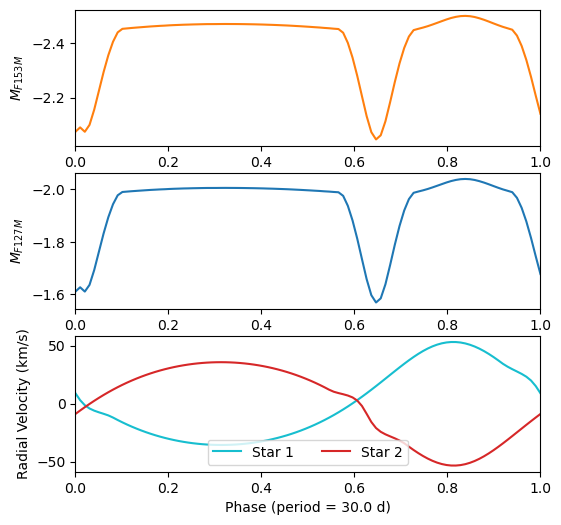

In [13]:
fig = plt.figure(figsize=(6,6))

# F153M mags subplot
ax_mag_153m = fig.add_subplot(3,1,1)

ax_mag_153m.plot(
    model_phases, modeled_mags_153m,
    '-', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$M_{F153M}$")

# F153M mags subplot
ax_mag_127m = fig.add_subplot(3,1,2)

ax_mag_127m.plot(
    model_phases, modeled_mags_127m,
    '-', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$M_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(3,1,3)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)


## Bonus: make mesh plots to aide visualization

Once again, we can add some panels for mesh visualizations of the stars. For this eccentric binary example, we can change the phase values for where to draw the meshes. Photometric max happens at ~0.85 and an eclipse happens at ~0.65 so let's include those.

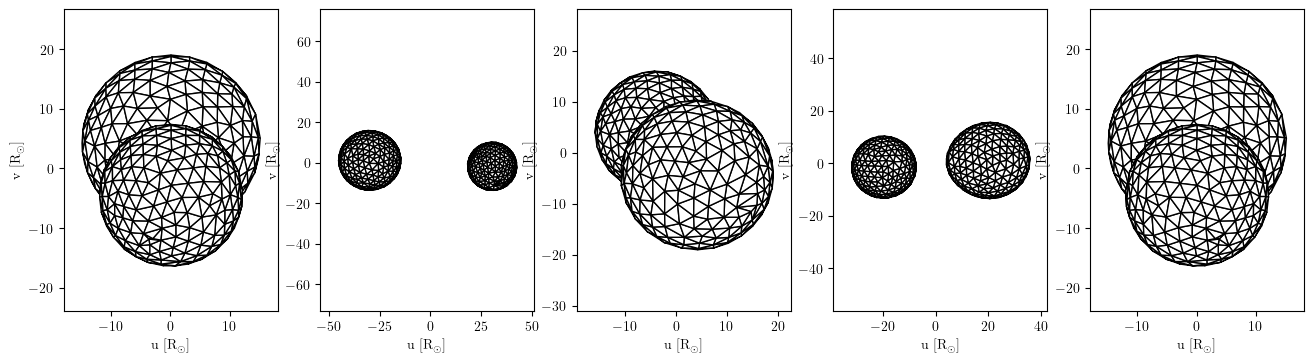

In [14]:
# Set up figure and specificy mesh plot outputs

fig = plt.figure(figsize=(8,8))

mesh_plot_phases = np.array([0.0, 0.25, 0.65, 0.85, 1.0])

modeled_observables, mesh_plot_out, fig = binary_model_obj.compute_obs(
    star1_params, star2_params, bin_params,
    make_mesh_plots=True,
    mesh_plot_phases=mesh_plot_phases,
    mesh_plot_fig=fig,
    mesh_plot_subplot_grid=(4,5),
    mesh_plot_subplot_grid_indexes=np.array([1, 2, 3, 4, 5,]),
    num_triangles=500,
)

# The mesh subplots show here since we have matplotlib inline enabled

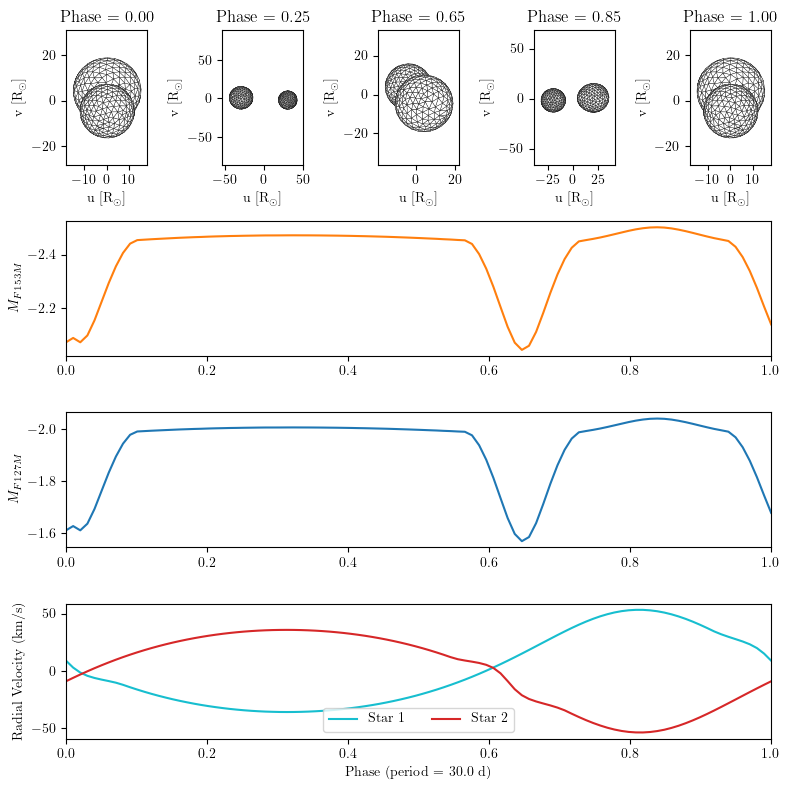

In [15]:
# Finish constructing the whole figure

# Fluxes in mags
modeled_mags = modeled_observables.obs[modeled_observables.phot_filt_filters[filter_153m]]

# RVs in km/s
modeled_rvs_star1 = modeled_observables.obs[modeled_observables.obs_rv_pri_filter]
modeled_rvs_star2 = modeled_observables.obs[modeled_observables.obs_rv_sec_filter]

# Label the mesh subplots
# # Remove empty axes
# for ax in fig.axes:
#     if ax.get_xlabel() == '':
#         ax.remove()

# # Make mesh axes share axes
# mesh_axes = []

for ax_index, phase in enumerate(mesh_plot_phases):
    ax = fig.axes[ax_index]
    
    ax.set_title(f'Phase = {phase:.2f}')
    
    # Decrease linewidths of the triangles in the mesh, for legibility in final plot
    for child in ax.get_children():
        if isinstance(child, mpl.collections.PolyCollection):
            child.set(lw=0.25)
    
    # mesh_axes.append(ax)

# Draw observables subplots
# F153m mags subplot
ax_mag_153m = fig.add_subplot(4,1,2)

ax_mag_153m.plot(
    model_phases, modeled_mags_153m,
    '-', color='C1',
)

ax_mag_153m.set_xlim([0, 1])

ax_mag_153m.invert_yaxis()
ax_mag_153m.set_ylabel(r"$M_{F153M}$")

# F127m mags subplot
ax_mag_127m = fig.add_subplot(4,1,3)

ax_mag_127m.plot(
    model_phases, modeled_mags_127m,
    '-', color='C0',
)

ax_mag_127m.set_xlim([0, 1])

ax_mag_127m.invert_yaxis()
ax_mag_127m.set_ylabel(r"$M_{F127M}$")

# RVs subplot
ax_rvs = fig.add_subplot(4,1,4)

ax_rvs.plot(
    model_phases, modeled_rvs_star1,
    '-', color='C9', label='Star 1',
)

ax_rvs.plot(
    model_phases, modeled_rvs_star2,
    '-', color='C3', label='Star 2',
)

ax_rvs.set_xlabel(f"Phase (period = {bin_params.period:.1f})")
ax_rvs.set_xlim([0, 1])

ax_rvs.set_ylabel("Radial Velocity (km/s)")

ax_rvs.legend(loc='lower center', ncol=2)

fig.set_size_inches(8, 8)
fig.tight_layout()

fig